# 1. Подготовка данных

In [2]:
import warnings
warnings.filterwarnings('ignore')

import optuna
import mlflow
import joblib
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, balanced_accuracy_score

mlflow.set_tracking_uri("http://127.0.0.1:8000")
client=mlflow.MlflowClient(tracking_uri='http://127.0.0.1:8000')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [8]:
df = pd.read_csv('Churn.csv')

In [9]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [11]:
# проверим наличие явных дубликатов:
df.duplicated().sum()

0

In [12]:
# посмотрим уникальные значения в категориальных признаках:
cat_columns = ['Geography', 'Tenure', 'NumOfProducts', 'Gender', 'HasCrCard', 'IsActiveMember']
for col in cat_columns:
    display(df[col].value_counts())

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

In [13]:
# посчитаем классы в целевом признаке:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Можно отметить, что дубликаты в датасете отсутствуют, в столбце Tenure есть около тысячи пропусков, а также несколько столбцов лучше вообще удалить, из них:

- RowNumber - это индекс строки в данных, важной информации не содержит;
- CustomerId - уникальный идентификатор клиента, по нему мы проверили дубликаты и теперь его можно удалить;
- Surname - фамилия, которая тоже не имеет связи с оттоком клиентов.

После проверки датасета на сбалансированность классов в таргете мы видим, что объектов отрицательного класса намного больше (почти в четыре раза), но все равно уходит примерно 20% клиентов. В столбце Geography находятся всего 3 уникальных значения: France, Germany и Spain. В столбце Tenure (сколько лет человек является клиентом банка) есть 909 пропусков. Заполним их значением -1, добавив логический параметр add_indicator=True. Есть несколько бинарных признаков (HasCrCard, IsActiveMember), которые выделим в отдельную категорию признаков.

In [14]:
# удалим ненужные столбцы:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [15]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [17]:
# сохраним признаки и целевой признак в отдельных переменных:
y = df['Exited']
X = df.drop('Exited', axis=1)

In [18]:
# разобьем исходные данные на обучающую и тестовую выборки в соотношении 4:1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [13]:
# посмотрим на размеры выборок:
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (8000, 10)
Размер тестовой выборки: (2000, 10)


In [14]:
# внесем в переменные списки все численные и категориальные признаки:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
binary_features = ['HasCrCard', 'IsActiveMember']
numeric_features = list(set(numeric_features) - set(binary_features))

# 2. Обучение модели без учёта дисбаланса классов (XGBoost)

Для автоматизации процесса подготовим численный и категориальный пайплайны.
- Для категориальных признаков (Geography, Gender) используем One Hot Encoding.
- Для заполнения пропусков используем SimpleImputer.
- Выполним трансформацию Йео-Джонсона.
- Для моделей логистической регрессии и SVM выполним масштабирование данных; для моделей, основанных на деревьях (XGBoost и Random Forest), выполнять его не будем.
- Объединим пайплайны классом ColumnTransformer.
- Используем optuna для автоматизированного поиска оптимальных гиперпараметров для моделей.
- Используем mlflow для того, чтобы легко выбрать лучшие модели среди всех экспериментов и при этом легко сравнивать метрики качества (будем сравнивать f1 на кроссвалидации, на тестовом наборе сравним f1, ROC-AUC и balanced accuracy).

In [15]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer()) 
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)

], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(random_state=12345))
])

In [16]:
def optuna_optimize(trial):
    param_grid = {
        'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 500),
        'model__max_depth': trial.suggest_int('model__max_depth', 2, 16),
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 1.0),
        'model__gamma': trial.suggest_float('model__gamma', 0.0, 20.0),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 0.0, 1.0),
        'model__min_child_weight': trial.suggest_float('model__min_child_weight', 0.0, 5.0)
    }

    pipe.set_params(**param_grid)
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [17]:
study_xgb = optuna.create_study(study_name="XGBoost Optuna Optimization Imbalanced",
                                direction='maximize')

In [18]:
study_xgb.optimize(optuna_optimize, n_trials=1000)

In [19]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_xgb.best_value))

Наилучшие значения гиперпараметров XGBoost: {'model__n_estimators': 408, 'model__max_depth': 9, 'model__learning_rate': 0.8585807178889413, 'model__gamma': 5.339859733348884, 'model__reg_lambda': 0.7845690703506853, 'model__min_child_weight': 1.5066771081317696}
f1_score на обучающем наборе: 0.599


In [20]:
with mlflow.start_run(nested=True,
                      run_name='xgb_pipeline_imbalanced'):

    best_params = study_xgb.best_params
    best_score = study_xgb.best_value
    mlflow.log_params(best_params)

    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    pred_proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc_xgb_imb = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_xgb_imb,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba)),
        'f1': f1_score(y_test, np.round(pred_proba))
    })

    mlflow.sklearn.log_model(pipe, 'xgb_pipeline_imbalanced')

# 3. Обучение моделей с учётом дисбаланса классов
## 3.1 Назначение разных весов классам (cost-sensitive learning)
### 3.1.1 Модель XGBoost

In [21]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)

], remainder='passthrough')

In [22]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0)
    }

    estimator = xgb.XGBClassifier(**param, 
                                  scale_pos_weight=3.91,
                                  random_state=12345)
    
    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [23]:
study_xgb_cw = optuna.create_study(study_name="XGBoost Optuna Optimization Class Weight",
                                direction='maximize')

In [24]:
study_xgb_cw.optimize(optuna_optimize, n_trials=1000)

In [25]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb_cw.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_xgb_cw.best_value))

Наилучшие значения гиперпараметров XGBoost: {'n_estimators': 196, 'max_depth': 12, 'learning_rate': 0.13109105604650967, 'gamma': 8.434935424758933, 'reg_lambda': 0.7892367276877359, 'min_child_weight': 0.9582414005952598}
f1_score на обучающем наборе: 0.615


In [26]:
with mlflow.start_run(nested=True,
                      run_name='xgb_pipeline_class_weight'):

    best_params = study_xgb_cw.best_params
    best_score = study_xgb_cw.best_value
    mlflow.log_params(best_params)

    xgb_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(**best_params,
                                    scale_pos_weight=3.91,
                                    random_state=12345))
    ])

    xgb_pipe_cw.fit(X_train, y_train) 

    pred_proba = xgb_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_xgb_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_xgb_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(xgb_pipe_cw, 'xgb_pipeline_class_weight')

### 3.1.2 Случайный лес

In [27]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), 
        'max_depth': trial.suggest_int('max_depth', 2, 10), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8)
    }

    estimator = RandomForestClassifier(**param, 
                                       class_weight='balanced',
                                       random_state=12345)

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [28]:
study_rf = optuna.create_study(study_name="RandomForest Optuna Optimization Class Weight",
                                direction='maximize')

In [29]:
study_rf.optimize(optuna_optimize, n_trials=100)

In [30]:
print("Наилучшие значения гиперпараметров Random Forest: {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_rf.best_value))

Наилучшие значения гиперпараметров Random Forest: {'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.621


In [31]:
with mlflow.start_run(nested=True,
                      run_name='rf_pipeline_class_weight'):

    best_params = study_rf.best_params
    best_score = study_rf.best_value
    mlflow.log_params(best_params)

    rf_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(**best_params,
                                         class_weight='balanced',
                                         random_state=12345))
    ])

    rf_pipe_cw.fit(X_train, y_train)

    pred_proba = rf_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_rf_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_rf_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(rf_pipe_cw, 'rf_pipeline_class_weight')

### 3.1.3 Логистическая регрессия

In [32]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
], remainder='passthrough')

In [33]:
def optuna_optimize(trial):
    param = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    }
    
    if param['solver'] == 'lbfgs':
        param['penalty'] = 'l2' 

    if param['solver'] == 'saga':
        param['penalty'] = 'elasticnet' 
        param['C'] = trial.suggest_float('C', 0.01, 100) 
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
        param['max_iter'] = 1000 
        
    estimator = LogisticRegression(**param,  
                                   class_weight='balanced',
                                   random_state=12345)

    log_reg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [34]:
study_log_reg = optuna.create_study(study_name="LogisticRegression Optuna Optimization Class Weight",
                                direction='maximize')

In [35]:
study_log_reg.optimize(optuna_optimize, n_trials=100)

In [36]:
print("Наилучшие значения гиперпараметров Logistic Regression: {}".format(study_log_reg.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_log_reg.best_value))

Наилучшие значения гиперпараметров Logistic Regression: {'solver': 'saga', 'C': 0.029066592494481222, 'l1_ratio': 0.4028748395604096}
f1_score на обучающем наборе: 0.495


In [37]:
with mlflow.start_run(nested=True,
                      run_name='log_reg_pipeline_class_weight'):

    best_params = study_log_reg.best_params
    best_score = study_log_reg.best_value
    mlflow.log_params(best_params)

    log_reg_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(**best_params,
                                     class_weight='balanced',
                                     random_state=12345))
    ])

    log_reg_pipe_cw.fit(X_train, y_train)

    pred_proba = log_reg_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_lr_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_lr_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(log_reg_pipe_cw, 'log_reg_pipeline_class_weight')

### 3.1.4 Метод опорных векторов

In [38]:
def optuna_optimize(trial):

    param = {
        'C': trial.suggest_float('C', 0.01, 3)  # какие значения может принимать С 
    }
 
    estimator = SVC(**param, 
                    class_weight='balanced',
                    random_state=12345,
                    probability=True)
    
    svc_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    score = cross_val_score(svc_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [39]:
study_svc = optuna.create_study(study_name="SVC Optuna Optimization Class Weight",
                                    direction='maximize')

In [40]:
study_svc.optimize(optuna_optimize, n_trials=10)

In [41]:
print("Наилучшие значения гиперпараметров SVC: {}".format(study_svc.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_svc.best_value))

Наилучшие значения гиперпараметров SVC: {'C': 2.416985930109804}
f1_score на обучающем наборе: 0.579


In [42]:
with mlflow.start_run(nested=True,
                      run_name='svc_pipeline_class_weight'):

    best_params = study_svc.best_params
    best_score = study_svc.best_value
    mlflow.log_params(best_params)

    svc_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(**best_params,
                      class_weight='balanced',
                      random_state=12345,
                      probability=True))
    ])

    svc_pipe_cw.fit(X_train, y_train)

    pred_proba = svc_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_svc_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_svc_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(svc_pipe_cw, 'svc_pipeline_class_weight')

## 3.2 Генерация синтетических данных (SMOTE)
### 3.2.1 Модель XGBoost

In [43]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
], remainder='passthrough')

In [44]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0)
    }

    estimator = xgb.XGBClassifier(**param,
                                  random_state=12345)

    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [45]:
study_xgb_smote = optuna.create_study(study_name="XGBoost Optuna Optimization SMOTE",
                                direction='maximize')

In [46]:
study_xgb_smote.optimize(optuna_optimize, n_trials=1000)

In [47]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_xgb_smote.best_value))

Наилучшие значения гиперпараметров XGBoost: {'n_estimators': 63, 'max_depth': 15, 'learning_rate': 0.15832529671587797, 'gamma': 11.638089482051441, 'reg_lambda': 0.017080812834569883, 'min_child_weight': 3.1315840621582343}
f1_score на обучающем наборе: 0.634


In [48]:
with mlflow.start_run(nested=True,
                      run_name='xgb_pipeline_smote'):

    best_params = study_xgb_smote.best_params
    best_score = study_xgb_smote.best_value
    mlflow.log_params(best_params)

    xgb_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', xgb.XGBClassifier(**best_params,
                                    random_state=12345))
    ])

    xgb_pipe_sm.fit(X_train, y_train)

    pred_proba = xgb_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_xgb_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_xgb_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(xgb_pipe_sm, 'xgb_pipeline_smote')

### 3.2.2 Случайный лес

In [49]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8)
    }

    estimator = RandomForestClassifier(**param,
                                       random_state=12345)

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [50]:
study_rf_smote = optuna.create_study(study_name="RandomForest Optuna Optimization SMOTE",
                               direction='maximize')

In [51]:
study_rf_smote.optimize(optuna_optimize, n_trials=100)

In [52]:
print("Наилучшие значения гиперпараметров RandomForest: {}".format(study_rf_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_rf_smote.best_value))

Наилучшие значения гиперпараметров RandomForest: {'n_estimators': 177, 'max_depth': 10, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.615


In [53]:
with mlflow.start_run(nested=True,
                      run_name='rf_pipeline_smote'):

    best_params = study_rf_smote.best_params
    best_score = study_rf_smote.best_value
    mlflow.log_params(best_params)

    rf_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', RandomForestClassifier(**best_params,
                                         random_state=12345))
    ])

    rf_pipe_sm.fit(X_train, y_train)

    pred_proba = rf_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_rf_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_rf_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(rf_pipe_sm, 'rf_pipeline_smote')

### 3.2.3 Логистическая регрессия

In [54]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
], remainder='passthrough')

In [55]:
def optuna_optimize(trial):
    param = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    }

    if param['solver'] == 'lbfgs':
        param['penalty'] = 'l2' 

    if param['solver'] == 'saga':
        param['penalty'] = 'elasticnet' 
        param['C'] = trial.suggest_float('C', 0.01, 100) # какие тут значения?
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
        param['max_iter'] = 1000 

    estimator = LogisticRegression(**param,
                                   random_state=12345)

    log_reg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [56]:
study_log_reg_smote = optuna.create_study(study_name="LogisticRegression Optuna Optimization SMOTE",
                                    direction='maximize')

In [57]:
study_log_reg_smote.optimize(optuna_optimize, n_trials=100)

In [58]:
print("Наилучшие значения гиперпараметров Logistic Regression: {}".format(study_log_reg_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_log_reg_smote.best_value))

Наилучшие значения гиперпараметров Logistic Regression: {'solver': 'lbfgs'}
f1_score на обучающем наборе: 0.493


In [59]:
with mlflow.start_run(nested=True,
                      run_name='log_reg_pipeline_smote'):

    best_params = study_log_reg_smote.best_params
    best_score = study_log_reg_smote.best_value
    mlflow.log_params(best_params)

    log_reg_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', LogisticRegression(**best_params,
                                     random_state=12345))
    ])

    log_reg_pipe_sm.fit(X_train, y_train)

    pred_proba = log_reg_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_lr_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_lr_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(log_reg_pipe_sm, 'log_reg_pipeline_smote')

### 3.2.4 Метод опорных векторов

In [60]:
def optuna_optimize(trial):

    param = {
        'C': trial.suggest_float('C', 0.01, 3)  
    }

    estimator = SVC(**param,
                    random_state=12345,
                    probability=True)

    svc_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(svc_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score

In [61]:
study_svc_smote = optuna.create_study(study_name="SVC Optuna Optimization SMOTE",
                                direction='maximize')

In [62]:
study_svc_smote.optimize(optuna_optimize, n_trials=10)

In [63]:
print("Наилучшие значения гиперпараметров SVC: {}".format(study_svc_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_svc_smote.best_value))

Наилучшие значения гиперпараметров SVC: {'C': 1.5530348857132203}
f1_score на обучающем наборе: 0.576


In [64]:
with mlflow.start_run(nested=True,
                      run_name='svc_pipeline_smote'):

    best_params = study_svc_smote.best_params
    best_score = study_svc_smote.best_value
    mlflow.log_params(best_params)

    svc_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', SVC(**best_params,
                      random_state=12345,
                      probability=True))
    ])

    svc_pipe_sm.fit(X_train, y_train)
    pred_proba = svc_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_svc_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_svc_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(svc_pipe_sm, 'svc_pipeline_smote')

In [65]:
colNames = ["XGBoost", "Random Forest", "Logistic Regression", "SVC"]
f1_results = {"Imbalanced":[study_xgb.best_value, '-', '-', '-'],
           "Class Weight":[study_xgb_cw.best_value, 
                           study_rf.best_value, 
                           study_log_reg.best_value, 
                           study_svc.best_value],
           "SMOTE":[study_xgb_smote.best_value, 
                    study_rf_smote.best_value, 
                    study_log_reg_smote.best_value, 
                    study_svc_smote.best_value]}

In [66]:
# результаты метрики f1 score на кросс-валидации:
f1_table = pd.DataFrame.from_dict(f1_results, orient='index', columns=colNames)

In [67]:
f1_table

,XGBoost,Random Forest,Logistic Regression,SVC
Imbalanced,0.598729,-,-,-
Class Weight,0.614797,0.621485,0.495472,0.578921
SMOTE,0.634221,0.615066,0.493169,0.575875


In [68]:
roc_auc_results = {"Imbalanced":[roc_auc_xgb_imb, '-', '-', '-'],
           "Class Weight":[roc_auc_xgb_cw,
                           roc_auc_rf_cw,
                           roc_auc_lr_cw,
                           roc_auc_svc_cw],
           "SMOTE":[roc_auc_xgb_sm,
                    roc_auc_rf_sm,
                    roc_auc_lr_sm,
                    roc_auc_svc_sm]}

In [69]:
# результаты метрики roc_auc на тесте:
roc_auc_table = pd.DataFrame.from_dict(roc_auc_results, orient='index', columns=colNames)

In [70]:
roc_auc_table

,XGBoost,Random Forest,Logistic Regression,SVC
Imbalanced,0.863135,-,-,-
Class Weight,0.864775,0.87042,0.788744,0.841361
SMOTE,0.867976,0.863804,0.787663,0.828519


# 4. Тестирование лучшей модели

Лучший результат метрики f1 на кросс-валидации показывает модель XGBoost с применением техники SMOTE, на втором месте - алгоритм Random Forest с назначением большего веса меньшему классу. При этом метрика ROC-AUC у первой равна 0,868, у второй - 0,87. Протестируем обе эти модели.


In [3]:
best_model_xgb = mlflow.sklearn.load_model('runs:/016f63ffd42f49bfac2b469c3a1a09c0/xgb_pipeline_smote')

In [4]:
best_model_rf = mlflow.sklearn.load_model('runs:/22433a40924543c8ad17218dc530dd27/rf_pipeline_class_weight')

In [20]:
pred_proba_xgb_smote = best_model_xgb.predict_proba(X_test)[:, 1]
pred_proba_rf_cw = best_model_rf.predict_proba(X_test)[:, 1]
print('Результаты метрик модели XGBoost:')
print()
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test, pred_proba_xgb_smote)))
print('f1 score: {:.4f}'.format(f1_score(y_test, np.round(pred_proba_xgb_smote))))
print('Balanced accuracy: {:.4f}'.format(balanced_accuracy_score(y_test, np.round(pred_proba_xgb_smote))))
print()
print('Результаты метрик модели Random Forest:')
print()
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test, pred_proba_rf_cw)))
print('f1 score: {:.4f}'.format(f1_score(y_test, np.round(pred_proba_rf_cw))))
print('Balanced accuracy: {:.4f}'.format(balanced_accuracy_score(y_test, np.round(pred_proba_rf_cw))))

Результаты метрик модели XGBoost:

ROC-AUC: 0.8680
f1 score: 0.6262
Balanced accuracy: 0.7670

Результаты метрик модели Random Forest:

ROC-AUC: 0.8704
f1 score: 0.6473
Balanced accuracy: 0.7938


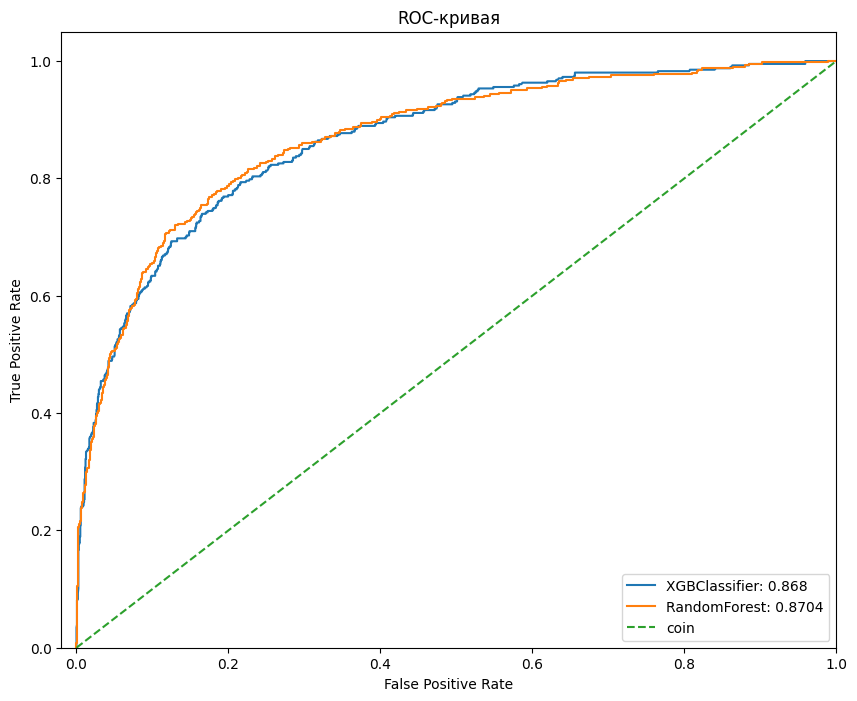

In [21]:
plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, pred_proba_xgb_smote)
plt.plot(fpr, tpr, label=f'XGBClassifier: {round(roc_auc_score(y_test, pred_proba_xgb_smote), 4)}')

fpr, tpr, thresholds = roc_curve(y_test, pred_proba_rf_cw)
plt.plot(fpr, tpr, label=f'RandomForest: {round(roc_auc_score(y_test, pred_proba_rf_cw), 4)}')

plt.plot([0, 1], [0, 1], linestyle='--', label='coin')

plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.legend(loc='lower right')

plt.show()

In [22]:
# сохраним лучшую модель:
joblib.dump(best_model_rf, 'best_model.pkl')

['best_model.pkl']

В ходе работы над проектом были проделаны следующие шаги:

1) Подготовлены данные к исследованию, а именно:

- убраны из данных неинформативные столбцы с номером строки, номером ID и фамилией клиента;

- обработаны пропуски в столбце Tenure - период, в течение которого человек является клиентом банка;

- сделано кодирование категориальных признаков методом One-Hot Encoding, подходящим для разных видов ML;;

- данные поделены на тренировочную, валидационную и тестовую выборки;

- проверен датасет на сбалансированность классов в таргете (20% положительных ответов);

- выполнена трансформация Йео-Джонсона;

- сделано масштабирование численных признаков для моделей SVM и логистической регрессии.

2) Проведено исследование задачи: построены четыре модели классификации: XGBoost, Случайный лес, Метод опорных векторов и Логистическая регрессия.

3) Устранен дисбаланс классов двумя способами: с помощью применения техники SMOTE и добавления модели гиперпараметра class_weight. На новых данных модель Random Forest показала результат выше при применении гиперпараметра class_weight. Подбор гиперпараметров с изменением веса редкого класса помог довести показатель F1-меры до 0,647. Применение техники SMOTE оказалось чуть менее эффективно. Наилучшее качество достигается при использовании гиперпараметров:
- n_estimators=150, 
- max_depth=10, 
- min_samples_leaf=4.

4) Проведено тестирование финальной модели на тестовой выборке. Можно подтвердить, что нам получилось справиться с дисбалансом классов и удалось получить метрику f1 > 0.59.